In [1]:
import pandas as pd
import numpy as np

frame = pd.read_csv("ab_browser_test.csv", sep=",", header=0)
frame.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [2]:
exp_clicks_count = frame[frame["slot"]=="exp"]["n_clicks"].sum()
control_clicks_count = frame[frame["slot"]=="control"]["n_clicks"].sum()
print "Exp clicks count difference percent: %.3f" % np.round(float(exp_clicks_count)*100./float(control_clicks_count)-100, 3)

Exp clicks count difference percent: 1.614


In [3]:
def get_bootstrap_samples(data, n_samples):
    data_length = len(data)
    indices = np.random.randint(0, data_length, (n_samples, data_length))
    return data[indices]

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries
#%%
np.random.seed(0)
n_boot_samples = 500
exp_clicks = get_bootstrap_samples(frame[frame["slot"]=="exp"]["n_clicks"].values, n_boot_samples)
control_clicks = get_bootstrap_samples(frame[frame["slot"]=="control"]["n_clicks"].values, n_boot_samples)

exp_clicks_means = map(np.mean, exp_clicks)
exp_clicks_medians = map(np.median, exp_clicks)

control_clicks_means = map(np.mean, control_clicks)
control_clicks_medians = map(np.median, control_clicks)

exp_means_interval = stat_intervals(exp_clicks_means, 0.05)
exp_medians_interval = stat_intervals(exp_clicks_medians, 0.05)

control_means_interval = stat_intervals(control_clicks_means, 0.05)
control_medians_interval = stat_intervals(control_clicks_medians, 0.05)

interval_means_diff = stat_intervals(map(lambda(x,y): x-y, zip(exp_clicks_means,control_clicks_means)), 0.05)
interval_medians_diff = stat_intervals(map(lambda(x,y): x-y, zip(exp_clicks_medians,control_clicks_medians)), 0.05)

print "95%% Confidence interval for exp means: [%f;%f]" % tuple(exp_means_interval)
print "95%% Confidence interval for control means: [%f;%f]" % tuple(control_means_interval)
print "95%% Confidence interval for exp medians: [%f;%f]" % tuple(exp_medians_interval)
print "95%% Confidence interval for control medians: [%f;%f]" % tuple(control_medians_interval)
print "95%% Confidence interval for difference between means: [%f;%f]" % tuple(interval_means_diff)
print "95%% Confidence interval for difference between medians: [%f;%f]" % tuple(interval_medians_diff)


95% Confidence interval for exp means: [11.507893;11.658866]
95% Confidence interval for control means: [11.206687;11.353475]
95% Confidence interval for exp medians: [5.000000;5.000000]
95% Confidence interval for control medians: [4.000000;4.000000]
95% Confidence interval for difference between means: [0.199603;0.404967]
95% Confidence interval for difference between medians: [1.000000;1.000000]


Populating the interactive namespace from numpy and matplotlib


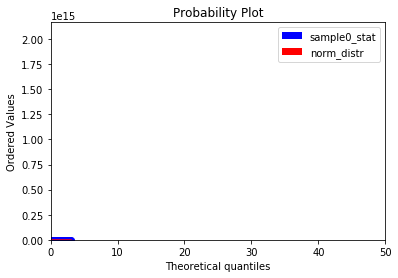

In [4]:
from scipy import stats
%pylab inline
sample_0 = control_clicks[0]
expected_frequences_s0 = [len(sample_0)*stats.norm.pdf(x) for x in range(min(sample_0), max(sample_0) + 1)]
pylab.xlim(0, 50)
pylab.bar(range(len(np.bincount(sample_0))), np.bincount(sample_0), color = 'b', label = 'sample0_stat')
pylab.bar(range(len(expected_frequences_s0)), expected_frequences_s0, color = 'r', label = 'norm_distr')
pylab.legend()

from scipy import stats
def calc_chisquare_stats(sample):
    mean = np.mean(sample)
    sample_size = len(sample)
    expected_means = [mean for x in xrange(0, sample_size)]
    stat = stats.chisquare(sample_size, expected_means, ddof=0, axis=0)
    return (mean, stat.statistic, stat.pvalue)
control_clicks_chi = map(calc_chisquare_stats, control_clicks)

mean_plot = stats.probplot(map(lambda (m,s,p): m, control_clicks_chi), dist = "norm", plot = pylab)

stat_plot = stats.probplot(map(lambda (m,s,p): s, control_clicks_chi), dist = "chi2", sparams=(n_boot_samples-1), plot = pylab)

In [5]:
print "Mean R^2: %f" % mean_plot[1][2]
print "Chi square R^2: %f" % stat_plot[1][2]

Mean R^2: 0.999176
Chi square R^2: 0.998489


In [6]:
exp_data = frame[frame["slot"]=="exp"]
control_data = frame[frame["slot"]=="control"]

exp_user_clicks = exp_data.groupby("userID").agg("sum")["n_clicks"]
control_user_clicks = control_data.groupby("userID").agg("sum")["n_clicks"]

mann_whitney_stat = stats.mannwhitneyu(control_user_clicks, exp_user_clicks, alternative="two-sided")
print "Mann-Whitney criterion pvalue result: %.4f" % np.round(mann_whitney_stat.pvalue, 4)
mann_whitney_stat

Mann-Whitney criterion pvalue result: 0.0000


MannwhitneyuResult(statistic=38901259929.0, pvalue=8.694294377520879e-75)

In [7]:
from statsmodels.sandbox.stats.multicomp import multipletests
exp_browser_names = set(exp_data["browser"])
exp_browser_data = {}
for browser_name in exp_browser_names:
    exp_browser_data[browser_name] = exp_data[exp_data["browser"]==browser_name]
control_browser_names = set(control_data["browser"])
control_browser_data = {}
for browser_name in control_browser_names:
    control_browser_data[browser_name] = control_data[control_data["browser"]==browser_name]
all_browser_names = exp_browser_names.union(control_browser_names)
mann_whitney_pvalues = []
for browser_name in all_browser_names:
    exp_b_user_clicks = exp_browser_data[browser_name]["n_clicks"].values
    control_b_user_clicks = control_browser_data[browser_name]["n_clicks"].values
    mann_whitney_stat = stats.mannwhitneyu(control_b_user_clicks, exp_b_user_clicks, alternative="two-sided")
    mann_whitney_pvalues.append(mann_whitney_stat.pvalue)
mann_whitney_pvalues_corrected = multipletests(mann_whitney_pvalues, alpha = 0.05, method = 'holm')
for b in zip(all_browser_names, mann_whitney_pvalues_corrected[0]):
    print "%s is statistically valuable: %r" % b
print "Count of not rejected hypothesis: %i" % len(filter(lambda x: not(x), mann_whitney_pvalues_corrected[0]))

Browser #2 is statistically valuable: False
Browser #4 is statistically valuable: False
Browser #22 is statistically valuable: False
Browser #20 is statistically valuable: False
Browser #17 is statistically valuable: False
Browser #14 is statistically valuable: True
Count of not rejected hypothesis: 5


In [8]:
for browser_name in all_browser_names:
    exp_no_click_count = float(exp_browser_data[browser_name]["n_nonclk_queries"].sum())
    exp_queries_count = float(exp_browser_data[browser_name]["n_queries"].sum())
    control_no_click_count = float(control_browser_data[browser_name]["n_nonclk_queries"].sum())
    control_queries_count = float(control_browser_data[browser_name]["n_queries"].sum())
    exp_percent = exp_no_click_count/exp_queries_count*100
    control_percent = control_no_click_count/control_queries_count*100
    print "%s no click queries percentage: exp=%f\tcontrol=%f\tdiff=%f" % (browser_name, exp_percent, control_percent, (control_percent-exp_percent))

Browser #2 no click queries percentage: exp=44.982747	control=45.962747	diff=0.980000
Browser #4 no click queries percentage: exp=45.142942	control=46.970930	diff=1.827988
Browser #22 no click queries percentage: exp=39.853947	control=40.593977	diff=0.740029
Browser #20 no click queries percentage: exp=38.977376	control=40.540485	diff=1.563108
Browser #17 no click queries percentage: exp=36.937413	control=36.299367	diff=-0.638046
Browser #14 no click queries percentage: exp=43.755617	control=57.590411	diff=13.834794
